In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
from sklearn.datasets import make_classification




In [ ]:
train_val = pd.read_csv('train_test_set3.csv')
train_val.reset_index(drop=True, inplace=True)

In [ ]:
train_val.isnull().sum()

sentences    219
labels         0
dtype: int64

In [ ]:
train_val = train_val.dropna()

In [ ]:
train_val.isnull().sum()

sentences    0
labels       0
dtype: int64

In [ ]:
print(train_val.info())
display(train_val.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91631 entries, 0 to 91849
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  91631 non-null  object
 1   labels     91631 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ MB
None


,sentences,labels
0,product fine good enough diced tomatoes arrive...,0
1,people whose dogs corn allergies limit purchas...,1
2,honey great ordered product times amazon one m...,0
3,taste good developed huge sugar crystals less ...,0
4,ordered product knowing cat loves newman organ...,0


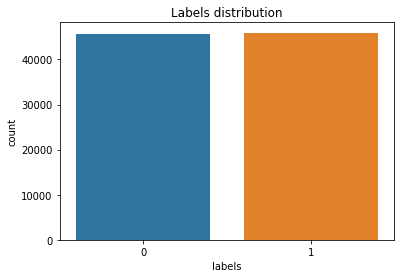

In [ ]:
sns.countplot(train_val['labels']);
plt.title('Labels distribution');

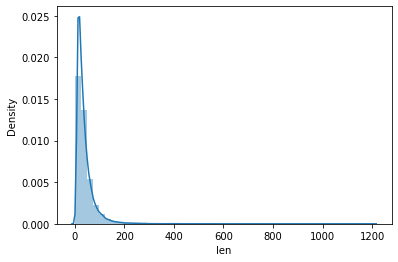

In [ ]:
train_val['len'] = train_val['sentences'].apply(lambda x: len(x.split()))
sns.distplot(train_val['len']);

Negative mean length: 41.02
Positive mean length: 37.37
Mean Difference: 3.66


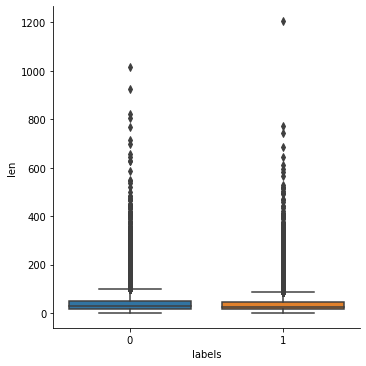

In [ ]:
neg_mean_len = train_val.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_val.groupby('labels')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
ax = sns.catplot(x='labels', y='len', data=train_val, kind='box')

In [ ]:
neg_array = train_val[train_val['labels']==0]['len'].values
pos_array = train_val[train_val['labels']==1]['len'].values
mean_diff = neg_mean_len - pos_mean_len

In [ ]:
def permutation_sample(data1, data2):
    # Permute the concatenated array: permuted_data
    data = np.concatenate((data1,data2))
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [ ]:
def draw_perm_reps(data_1, data_2, size=1):

    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)

    return perm_replicates

In [ ]:
perm_replicates = draw_perm_reps(neg_array, pos_array,
                                 size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= mean_diff) / len(perm_replicates)

print(f'p-value = {p}')

p-value = 0.0


In [ ]:
#Baseline - LogReg(Tf-ldf)

In [ ]:
def prediction(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    conf = confusion_matrix(y_valid, pred)
    precision = precision_score(y_valid, pred)
    recall = recall_score(y_valid, pred)
    roc_auc = roc_auc_score(y_valid, pred)
    joblib.dump(model, f"model_acc_{acc:.5f}.pkl")
    return model, acc, f1, conf, recall, precision, roc_auc

In [ ]:
transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), 
                              lowercase=True, max_features=100000)
X = transformer.fit_transform(train_val['sentences'])
y = train_val.labels

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)
model = LogisticRegression(C=1, random_state=42, n_jobs=-1)
fit_model, acc, f1, conf, recall, precision, roc_auc = prediction(model, X_train, y_train, X_valid, y_valid)

In [ ]:
print(f"Accuracy: {acc:.5f}")
print(f"F1_Score: {f1:.5f}")
print(f"Confusion Matrix: {conf}")
print(f"Recall: {recall:.5f}")
print(f"Precision: {precision:.5f}")
print(f"ROC_AUC: {roc_auc:.5f}")


Accuracy: 0.88552
F1_Score: 0.88619
Confusion Matrix: [[8061 1081]
 [1017 8168]]
Recall: 0.88928
Precision: 0.88312
ROC_AUC: 0.88552
